In [1]:
import nltk
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
def parse_metrics_filename(filename):    
    name_parts = filename.split("_")
    
    # Model size
    model_sizes = ["gpt2-large", "gpt2-medium", "gpt2-xl", "gpt2"]
    model_size = None
    for size in model_sizes:
        if size in filename:
            model_size = size
            break
            
    if "not_finetuned" in filename:
        return (model_size, None, None, None, None)
            
    if model_size is None:
        print(f"Cannot find model size in {filename}")
        return
    
    # Learning rate
    lr = None
    if "lr" in filename:
        for part in name_parts:
            if "lr" in part:
                lr = float(part[2:])
    else:
        for part in name_parts:
            if "e-" in part:
                lr = float(part)
    
    if lr is None:
        print(f"Cannot find learning rate in {filename}")
        return
    
    # Unfrozen block
    blk = None
    if "blk" in filename:
        for part in name_parts:
            if "blk" in part:
                blk = float(part[3:])
    else:
        blk = 1.0
        
    # Check if head is frozen
    head_frozen = False
    if blk < 1.0:
        head_frozen = "without_head" in filename
        
    # Epoch
    epoch = None
    if "checkpoint" in filename:
        for part in name_parts:
            if "checkpoint" in part:
                epoch = int(int(part[10:].split(".")[0])/5888)
    elif "epoch" in filename:
        epoch = int(name_parts[-1].split(".")[0])
    
    if epoch is None:
        print(f"Cannot find epoch in {filename}")
        return
    
    return (model_size, lr, blk, epoch, head_frozen)

def process_file(filename, force=False):
    if not force:
        for decode in ["top-p", "temperature", "beam_search"]:
            if decode in filename:
                return
        
    res = parse_metrics_filename(filename)
    if res is None:
        return None
        
    metrics_path = 'metrics'
    model_size, lr, blk, epoch, head_frozen = res
    df = pd.read_csv(f"{metrics_path}/{filename}")
    
    similarity_score_stats = dict(df["similarity_score"].describe().drop(["count",  "max"]))
    exact_match_stats = dict(df["exact_match"].describe().drop(["count", "min", "25%", "50%", "75%"]))
    
    exact_match_count = dict(df["exact_match"].value_counts().drop(0).sort_index(ascending=False).cumsum()[::-1])
    exact_match_count[0] = len(df.index) - exact_match_count[1]
    
    similarity_score_stats = {f'{k}_similarity_score': v for k, v in similarity_score_stats.items()}
    exact_match_stats = {f'{k}_exact_match': v for k, v in exact_match_stats.items()}
    exact_match_count = {f'exact_match_{k}': v for k, v in exact_match_count.items()}
    
    return {
        **{
            "size": model_size,
            "lr": lr,
            "blk": blk,
            "epoch": epoch,
            "head_frozen": head_frozen
        },
        **similarity_score_stats,
        **exact_match_stats,
        **exact_match_count,
    }

def plot_exact_match(df, min_idx, max_idx):
    ticks = range(min_idx, max_idx + 1)
    plot_df = df[min_idx:max_idx+1]
    fig, ax = plt.subplots(2, 1, sharex=True)
    plot_df.plot(marker='*', ax=ax[0], xlabel = "Exact match count", ylabel="Frequency", xticks=ticks)
    np.log(plot_df).plot(marker='*', ax=ax[1], xlabel = "Exact match count", ylabel="Log of Frequency", xticks=ticks)
    ax[1].get_legend().remove()
    fig.set_figwidth(5)
    fig.set_figheight(5)
    fig.tight_layout()
    
    

In [3]:
df = pd.read_csv("./agg_metrics.csv")

In [4]:
# Analyze model size effect

size_df = df.loc[
    (df["lr"] == 1e-05) & (
        ((df["size"] == "gpt2") & (df["epoch"] == 19)) |
        ((df["size"] == "gpt2-medium") & (df["epoch"] == 9)) |
        ((df["size"] == "gpt2-large") & (df["epoch"] == 4) & (df["blk"] == 1.0)) |
        ((df["size"] == "gpt2-xl") & (df["epoch"] == 2))
    )
]
print(size_df[["size", "mean_similarity_score", "50%_similarity_score", "mean_exact_match", "max_exact_match"]].sort_values("mean_similarity_score").to_string())

           size  mean_similarity_score  50%_similarity_score  mean_exact_match  max_exact_match
77         gpt2               0.750260              0.799789          0.827835             37.0
52  gpt2-medium               0.758465              0.808372          0.950753             54.0
1    gpt2-large               0.764234              0.815082          1.017812             54.0
62      gpt2-xl               0.764552              0.813220          1.055318             39.0


In [5]:
size_plot_df = pd.wide_to_long(size_df, "exact_match_", i="size", j="count")["exact_match_"].reset_index(
    level=["size"]).pivot(
    columns = "size", values = "exact_match_")

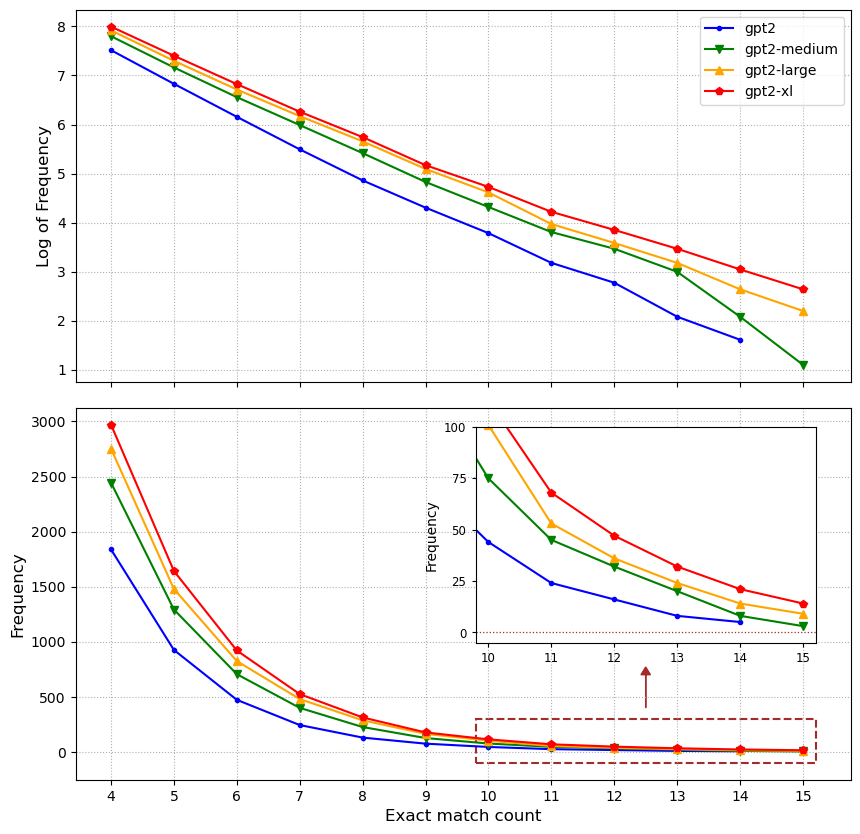

In [24]:
Colors = {0:'b', 1:'g', 2:'orange', 3:'r'}
labels = ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']
markers = ['.', 'v', '^', 'p']
Min_x, Max_x = 4, 15
df_tmp = size_plot_df[Min_x:Max_x+1]
Size_axis_label = 12
C_annot = 'brown'

fig, ax=plt.subplots(2,1, figsize=(10,8), sharex=True, gridspec_kw={'hspace':0.07})
ax[1].add_patch(plt.Rectangle((9.8, -100), 5.4, 400, ls="--", ec=C_annot, fc="none", lw=1.5))
ax[1].arrow(12.5, 400, 0, 300, head_width=0.15, head_length=70, fc=C_annot, ec=C_annot)

axins1 = inset_axes(ax[1], width="100%", height="100%",
                   bbox_to_anchor=(.507, .35, .439, .58),
                   bbox_transform=ax[1].transAxes, loc=3)

axins1.set(xlim=(9.8, 15.2), ylim=(-5,100))
axins1.set_yticks(np.linspace(0,100,5))
axins1.tick_params(size=3, labelsize=8, labelbottom=True)

for i in range(len(labels)):
    y_tmp = np.log(df_tmp[labels[i]].values)
    x_tmp = np.arange(Min_x, Max_x+1)
    ax[0].plot(x_tmp, y_tmp, c=Colors[i], marker=markers[i], label=labels[i])

    
    y_tmp = np.array(df_tmp[labels[i]].values)
    # y_tmp[np.isnan(y_tmp)] = 0
    ax[1].plot(x_tmp, y_tmp, c=Colors[i], marker=markers[i], label=labels[i])

    axins1.plot(x_tmp, y_tmp, c=Colors[i], marker=markers[i], label=labels[i])
    
ax[0].set_ylabel('Log of Frequency', size=Size_axis_label)
ax[0].grid(ls=':')
ax[0].legend()
ax[1].set_ylabel('Frequency', size=Size_axis_label)
ax[1].set_xlabel('Exact match count', size=Size_axis_label)
ax[1].set_xticks(x_tmp)
ax[1].grid(ls=':')
# axins1.grid(ls=':')
axins1.axhline(y=0, ls=':', c='brown', lw=0.9)
axins1.set_ylabel('Frequency', size=Size_axis_label-2)
axins1.tick_params(axis='both', which='major', labelsize=8.5)
fig.set_figheight(10)
# plt.savefig('./plots/size_zoomed.pdf', bbox_inches='tight', facecolor='w')


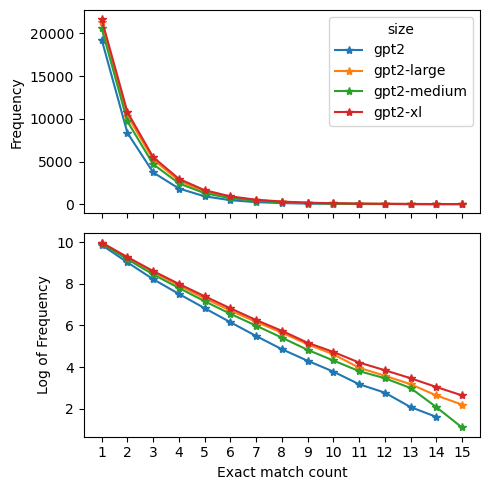

In [7]:
plot_exact_match(size_plot_df, 1, 15)
# plt.savefig("./plots/size.png", bbox_inches='tight')

In [9]:
# Analyze frozen block effect

frozen_df = df.loc[
    ((df["size"] == "gpt2-large") & (df["blk"] == 1.0) & (df["lr"] == 1e-05) & (df["epoch"] == 4) & (df["head_frozen"] == False)) |
    ((df["blk"] == 0.7) & (df["lr"] == 5e-07) & (df["epoch"] == 2) & (df["head_frozen"] == True)) |
    ((df["blk"] == 0.4) & (df["lr"] == 1e-06) & (df["epoch"] == 3) & (df["head_frozen"] == True)) |
    ((df["blk"] == 0.7) & (df["lr"] == 5e-07) & (df["epoch"] == 2) & (df["head_frozen"] == False)) |
    ((df["blk"] == 0.4) & (df["lr"] == 5e-07) & (df["epoch"] == 2) & (df["head_frozen"] == False)) |
    ((df["blk"] == 0.0) & (df["lr"] == 1e-05) & (df["epoch"] == 2) & (df["head_frozen"] == False))
]
print(frozen_df[["blk", "head_frozen", "mean_similarity_score", "50%_similarity_score", "mean_exact_match", "max_exact_match"]].sort_values("mean_similarity_score").to_string())

    blk head_frozen  mean_similarity_score  50%_similarity_score  mean_exact_match  max_exact_match
13  0.0       False               0.746644              0.798500          0.789082             16.0
28  0.4       False               0.749555              0.799484          0.810306             21.0
32  0.4        True               0.749924              0.800240          0.851882             20.0
44  0.7       False               0.751836              0.801748          0.847388             16.0
49  0.7        True               0.751978              0.801881          0.863224             13.0
1   1.0       False               0.764234              0.815082          1.017812             54.0


In [10]:
frozen_plot_df = pd.wide_to_long(frozen_df, "exact_match_", i=["blk", "head_frozen"], j="count")["exact_match_"].reset_index(
    level=["blk", "head_frozen"]).pivot(
    columns = ["blk", "head_frozen"], values = "exact_match_")

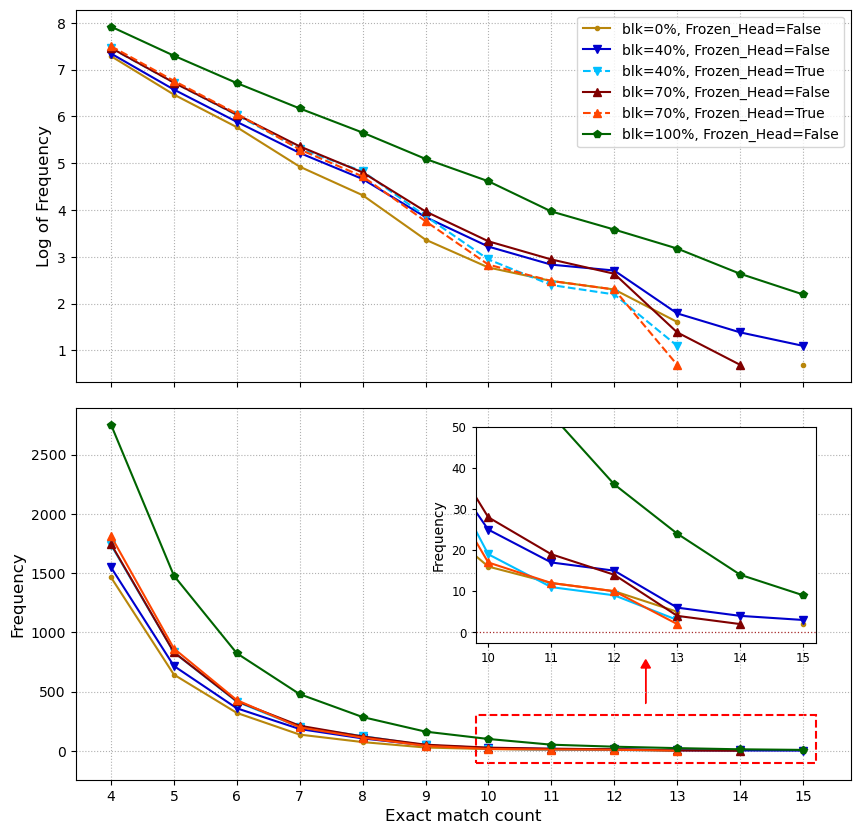

In [20]:
Colors = {0:'darkgoldenrod', 1:'mediumblue', 2:'deepskyblue', 3:'maroon', 4:'orangered', 5:'darkgreen'}
labels = [(0.0, False), (0.4, False), (0.4,  True), (0.7, False), (0.7,  True), (1.0, False)]
markers = ['.', 'v', 'v', '^', '^', 'p']
LS = ['-', '-', '--', '-', '--', '-']
Min_x, Max_x = 4, 15
df_tmp = frozen_plot_df[Min_x:Max_x+1]
Size_axis_label = 12
C_annot = 'r'

fig, ax=plt.subplots(2,1, figsize=(10,8), sharex=True, gridspec_kw={'hspace':0.07})
ax[1].add_patch(plt.Rectangle((9.8, -100), 5.4, 400, ls="--", ec=C_annot, fc="none", lw=1.5))
ax[1].arrow(12.5, 400, 0, 300, head_width=0.15, head_length=70, fc=C_annot, ec=C_annot)

axins1 = inset_axes(ax[1], width="100%", height="100%",
                   bbox_to_anchor=(.507, .35, .439, .58),
                   bbox_transform=ax[1].transAxes, loc=3)

axins1.set(xlim=(9.8, 15.2), ylim=(-2.5,50))
axins1.set_yticks(np.linspace(0,50,6))
axins1.tick_params(size=3, labelsize=8, labelbottom=True)

for i in range(len(labels)):
    y_tmp = np.log(df_tmp[labels[i]].values)
    x_tmp = np.arange(Min_x, Max_x+1)
    ax[0].plot(x_tmp, y_tmp, c=Colors[i], marker=markers[i], ls=LS[i], label=f"blk={labels[i][0]*100:.0f}%, Frozen_Head={labels[i][1]}")

    
    y_tmp = np.array(df_tmp[labels[i]].values)
    ax[1].plot(x_tmp, y_tmp, c=Colors[i], marker=markers[i])

    axins1.plot(x_tmp, y_tmp, c=Colors[i], marker=markers[i])
    
ax[0].set_ylabel('Log of Frequency', size=Size_axis_label)
ax[0].grid(ls=':')
ax[0].legend()
ax[1].set_ylabel('Frequency', size=Size_axis_label)
ax[1].set_xlabel('Exact match count', size=Size_axis_label)
ax[1].set_xticks(x_tmp)
ax[1].grid(ls=':')
# axins1.grid(ls=':')
axins1.axhline(y=0, ls=':', c='brown', lw=0.9)
axins1.set_ylabel('Frequency', size=Size_axis_label-2)
axins1.tick_params(axis='both', which='major', labelsize=8.5)
fig.set_figheight(10)
plt.savefig('./plots/frozen_zoomed.pdf', bbox_inches='tight', facecolor='w')


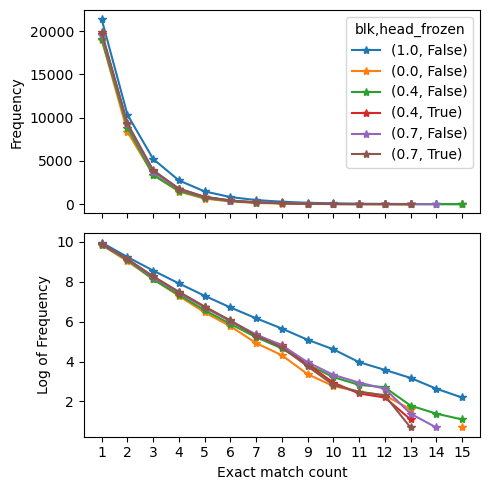

In [11]:
plot_exact_match(frozen_plot_df, 1, 15)
# plt.savefig("./plots/frozen.png", bbox_inches='tight')

In [12]:
# Analyze different decoding methods

greedy_df = process_file("metrics_model_gen_gpt2-large_5e-05_equal_dataset_50000_epoch_4.csv", force=True)
beam_search_df = process_file("metrics_model_gen_gpt2-large_equal_dataset_50000_beam_search_lr5e-05_epoch_4.csv", force=True)
temp_df = process_file("metrics_model_gen_gpt2-large_equal_dataset_50000_temperature_lr5e-05_epoch_4.csv", force=True)
top_p_df = process_file("metrics_model_gen_gpt2-large_equal_dataset_50000_top-p_lr5e-05_epoch_4.csv", force=True)

greedy_df["method"] = "greedy"
beam_search_df["method"] = "beam search (num_beam=8)"
temp_df["method"] = "random sampling (temp=0.85)"
top_p_df["method"] = "top p sampling (p=0.85)"

decode_df = pd.DataFrame([greedy_df, beam_search_df, temp_df, top_p_df]).fillna(0)

In [13]:
print(decode_df[["method", "mean_similarity_score", "50%_similarity_score", "mean_exact_match", "max_exact_match"]].sort_values("mean_similarity_score").to_string())

                        method  mean_similarity_score  50%_similarity_score  mean_exact_match  max_exact_match
2  random sampling (temp=0.85)               0.746285              0.792525          1.126353             39.0
3      top p sampling (p=0.85)               0.747955              0.793359          1.146988             39.0
1     beam search (num_beam=8)               0.769780              0.817773          1.588612             39.0
0                       greedy               0.777551              0.828516          1.615882             54.0


In [13]:
decode_plot_df = pd.wide_to_long(decode_df, "exact_match_", i="method", j="count")["exact_match_"].reset_index(
    level=["method"]).pivot(
    columns = "method", values = "exact_match_")

/scratch/gypsum-gpu186/7518327/ipykernel_860666/55268926.py:22: RuntimeWarning: divide by zero encountered in log
  y_tmp = np.log(df_tmp[labels[i]].values)
/scratch/gypsum-gpu186/7518327/ipykernel_860666/55268926.py:22: RuntimeWarning: divide by zero encountered in log
  y_tmp = np.log(df_tmp[labels[i]].values)


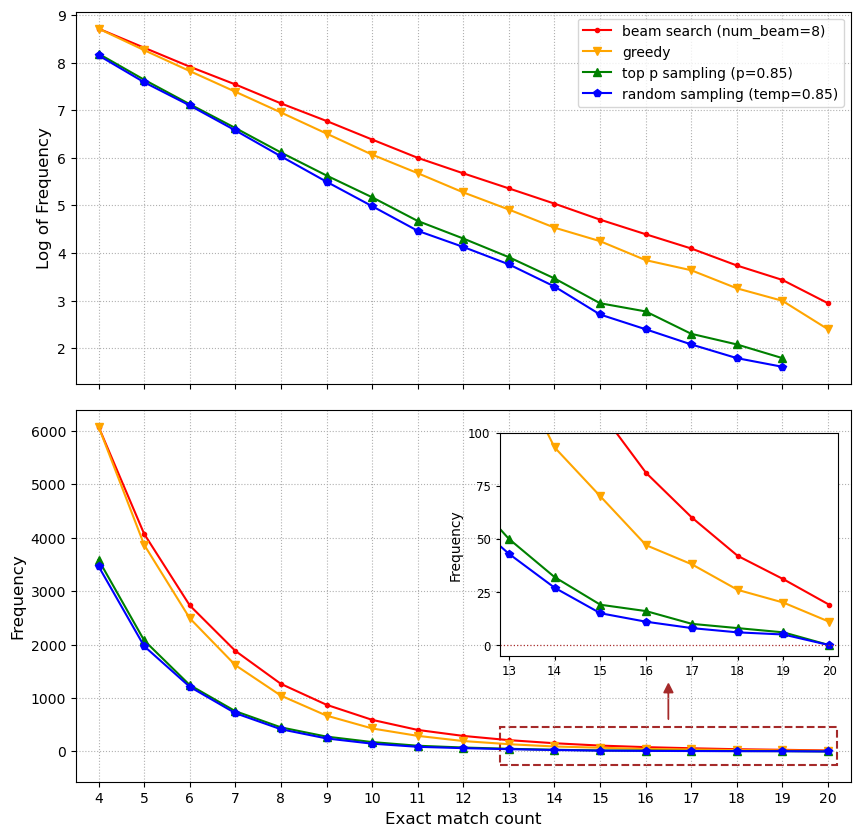

In [21]:
Colors = {3:'b', 2:'g', 1:'orange', 0:'r'}
labels = ['beam search (num_beam=8)', 'greedy', 'top p sampling (p=0.85)', 'random sampling (temp=0.85)']
markers = ['.', 'v', '^', 'p']
Min_x, Max_x = 4, 20
df_tmp = decode_plot_df[Min_x:Max_x+1]
Size_axis_label = 12
C_annot = 'brown'

fig, ax=plt.subplots(2,1, figsize=(10,8), sharex=True, gridspec_kw={'hspace':0.07})
ax[1].add_patch(plt.Rectangle((12.8, -250), 7.4, 700, ls="--", ec=C_annot, fc="none", lw=1.5))
ax[1].arrow(16.5, 600, 0, 500, head_width=0.2, head_length=170, fc=C_annot, ec=C_annot)

axins1 = inset_axes(ax[1], width="100%", height="100%",
                   bbox_to_anchor=(.538, .32, .437, .6),
                   bbox_transform=ax[1].transAxes, loc=3)

axins1.set(xlim=(12.8, 20.2), ylim=(-5,100))
axins1.set_yticks(np.linspace(0,100,5))
axins1.tick_params(size=3, labelsize=8, labelbottom=True)

for i in range(len(labels)):
    y_tmp = np.log(df_tmp[labels[i]].values)
    x_tmp = np.arange(Min_x, Max_x+1)
    ax[0].plot(x_tmp, y_tmp, c=Colors[i], marker=markers[i], label=labels[i])

    
    y_tmp = np.array(df_tmp[labels[i]].values)
    # y_tmp[np.isnan(y_tmp)] = 0
    ax[1].plot(x_tmp, y_tmp, c=Colors[i], marker=markers[i], label=labels[i])

    axins1.plot(x_tmp, y_tmp, c=Colors[i], marker=markers[i], label=labels[i])
    
ax[0].set_ylabel('Log of Frequency', size=Size_axis_label)
ax[0].grid(ls=':')
ax[0].legend()
ax[1].set_ylabel('Frequency', size=Size_axis_label)
ax[1].set_xlabel('Exact match count', size=Size_axis_label)
ax[1].set_xticks(x_tmp)
ax[1].set_xlim(3.5,20.5)
ax[1].grid(ls=':')
# axins1.grid(ls=':')
axins1.axhline(y=0, ls=':', c='brown', lw=0.9)
axins1.set_ylabel('Frequency', size=Size_axis_label-2)
axins1.tick_params(axis='both', which='major', labelsize=8.5)
fig.set_figheight(10)
plt.savefig('./plots/decode_zoomed.pdf', bbox_inches='tight', facecolor='w')


/home/sgoodarzitae_umass_edu/anaconda3/envs/myenvNLP/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


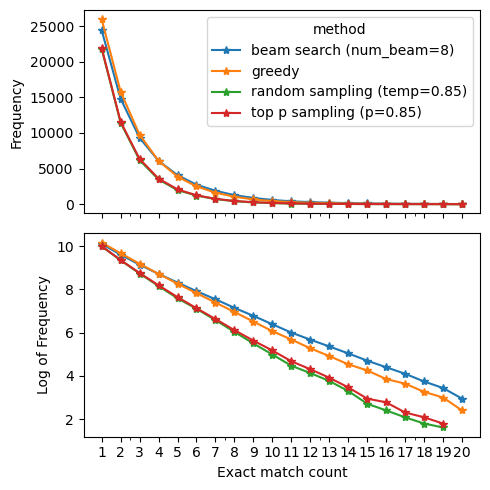

In [16]:
plot_exact_match(decode_plot_df, 1, 20)
# plt.savefig("./plots/decode.png", bbox_inches='tight')